In [198]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [199]:
os.listdir('input/')

['sample_submission.csv', 'test', 'train', 'voice-commands']

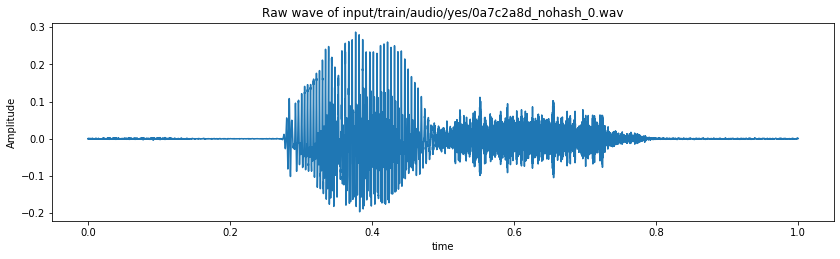

In [208]:
train_audio_path = 'input/train/audio'
samples, sample_rate = librosa.load(train_audio_path+'/yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [209]:
ipd.Audio(samples, rate=sample_rate)

In [210]:
print(sample_rate)

16000


In [211]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [212]:
labels=os.listdir(train_audio_path)

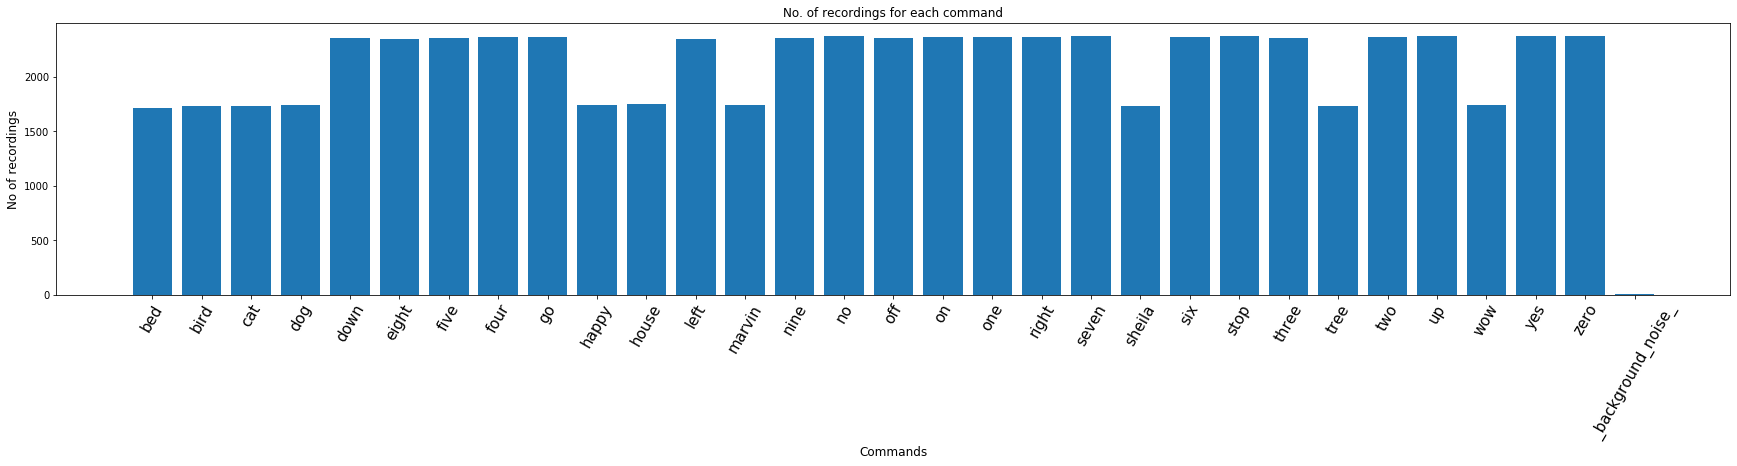

In [213]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [220]:
labels=['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'bed', 'bird', 'cat', 'dog',  'happy', 'house', 'marvin', 'sheila', 'tree', 'wow']

(array([1.200e+01, 2.000e+01, 1.800e+02, 1.590e+02, 3.760e+02, 6.480e+02,
        9.670e+02, 8.000e+02, 1.419e+03, 6.014e+04]),
 array([0.3715625 , 0.43440625, 0.49725   , 0.56009375, 0.6229375 ,
        0.68578125, 0.748625  , 0.81146875, 0.8743125 , 0.93715625,
        1.        ]),
 <a list of 10 Patch objects>)

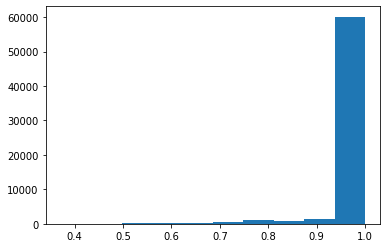

In [221]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [222]:
train_audio_path = 'input/train/audio/'
bg_files = os.listdir('input/train/audio/_background_noise_/')
bg_files.remove('README.md')
chosen_bg_file = bg_files[np.random.randint(6)]
bg, sr = librosa.load('input/train/audio/_background_noise_/'+chosen_bg_file, sr=None)


In [223]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        start_ = np.random.randint(bg.shape[0]-samples.shape[0])
        bg_slice = bg[start_ : start_+samples.shape[0]]
        sample_with_bg = samples * np.random.uniform(0.8, 1.2) + bg_slice * np.random.uniform(0, 0.1)
        sample_with_bg  = librosa.resample(sample_with_bg, sample_rate, 8000)
        if(len(sample_with_bg)== 8000) : 
            all_wave.append(sample_with_bg)
            all_label.append(label)

nine
yes
no
up
down
left
right
on
off
stop
go
zero
one
two
three
four
five
six
seven
eight
bed
bird
cat
dog
happy
house
marvin
sheila
tree
wow


In [224]:
print(len(all_wave))

58252


In [225]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [226]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [227]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [228]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [ ]:
from tensorflow.keras.models import Model, load_model,Sequential

from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

from kapre import STFT, Magnitude, MagnitudeToDecibel
K.clear_session()


input_shape = (8000, 1)  # mono signal
n_fft = 1024
n_hop = n_fft // 2
kwargs = {
    'sample_rate': 8000,
    'n_freq': n_fft // 2 + 1,
    'n_mels': 128,
    'f_min': 0.0,
    'f_max': 8000
}

models = Sequential()
models.add(kapre.STFT(n_fft=n_fft, hop_length=n_hop, input_shape=input_shape))
models.add(Magnitude())
models.add(ApplyFilterbank(type='mel', filterbank_kwargs=kwargs))

models.add(L.Conv2D(20, (5, 1), activation='relu', padding='same'))
models.add(L.BatchNormalization())
models.add(L.MaxPooling2D((2, 1)))
models.add(L.Dropout(0.03))

models.add(L.Conv2D(40, (3, 3), activation='relu', padding='same'))
models.add(L.BatchNormalization())
models.add(L.MaxPooling2D((2, 2)))
models.add(L.Dropout(0.01))

models.add(L.Conv2D(80, (3, 3), activation='relu', padding='same'))
models.add(L.BatchNormalization())
models.add(L.MaxPooling2D((2, 2)))
models.add(L.Dropout(0.01))

models.add(L.Flatten())
models.add(L.Dense(64, activation='relu'))
models.add(L.Dropout(0.01))
models.add(L.Dense(32, activation='relu'))
models.add(L.Dropout(0.01))


models.add(L.Dense(len(labels), activation='softmax'))

models.summary()

In [263]:
models.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [264]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initLearningRate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    learningRate = initLearningRate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (learningRate < 4e-5):
        learningRate = 4e-5
      
    print('Changing learning rate to {}'.format(learningRate))
    return learningRate
learningRate = LearningRateScheduler(step_decay)

In [265]:

earlystop = EarlyStopping(monitor='val_loss', patience=10,
                             verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('modelBestEpoch.h5', monitor='val_acc', verbose=1, save_best_only=True)



In [266]:
history=models.fit(x_tr, y_tr ,epochs=60,
                    callbacks=[earlystop, checkpoint, learningRate], validation_data=(x_val,y_val))

models.save('modelLastEpoch.h5')

Changing learning rate to 0.001
Epoch 1/60
1457/1457 [==============================] - 186s 128ms/step - loss: 2.2102 - accuracy: 0.3346 - val_loss: 2.9856 - val_accuracy: 0.2801 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/60
1457/1457 [==============================] - 189s 130ms/step - loss: 1.4207 - accuracy: 0.5673 - val_loss: 1.2731 - val_accuracy: 0.6179 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/60
1457/1457 [==============================] - 187s 128ms/step - loss: 1.1387 - accuracy: 0.6539 - val_loss: 2.4315 - val_accuracy: 0.4826 - lr: 0.0010
Changing learning rate to 0.001
Epoch 4/60
1457/1457 [==============================] - 187s 128ms/step - loss: 0.9816 - accuracy: 0.7025 - val_loss: 0.9811 - val_accuracy: 0.7024 - lr: 0.0010
Changing learning rate to 0.001
Epoch 5/60
1457/1457 [==============================] - 187s 129ms/step - loss: 0.8829 - accuracy: 0.7301 - val_loss: 1.0776 - val_accuracy: 0.6834 - lr: 0.0010
Changing learning rate to 0.001
Epo

In [321]:
from keras.models import load_model
model=load_model('modelLastEpoch.h5',custom_objects={'STFT': STFT,'Magnitude':Magnitude,'ApplyFilterbank':ApplyFilterbank})

In [269]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [274]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: zero


In [275]:
print("Text:",predict(samples))

Text: zero


In [325]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'input/voice-commands/myvoice/voice.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [326]:
os.listdir('input/voice-commands/myvoice')

['cat.wav', 'off.wav', 'stop.wav', 'voice.wav', 'yes.wav']

In [327]:
filepath='input/voice-commands/myvoice'

In [328]:
#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'voice.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)              

In [329]:
#converting voice commands to text
predict(samples)

'two'